# Data Setup

Downloads and sets up the raw training data for models

### PASCAL data setup

In [1]:
import requests
import tarfile
import os
from pathlib import Path

In [4]:
# directory setup
DATA_PATH = Path("..") / "data"
PASCAL_PARTS_PATH = DATA_PATH / "PASCAL_PARTS"
os.makedirs(PASCAL_PARTS_PATH, exist_ok="true")

In [5]:
# PASCAL_PARTS dataset url
PASCAL_PARTS_URL = "https://roozbehm.info/pascal-parts/trainval.tar.gz"

# download and extract
response = requests.get(PASCAL_PARTS_URL, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|gz")
file.extractall(path=PASCAL_PARTS_PATH)
print("PASCAL-Parts downloaded")

PASCAL-Parts downloaded


In [10]:
# PASCAL images path
PASCAL_IMAGES_PATH = DATA_PATH / "PASCAL_IMAGES"
os.makedirs(PASCAL_IMAGES_PATH, exist_ok="true")

# PASCAL Images url
PASCAL_IMAGES = "http://host.robots.ox.ac.uk/pascal/VOC/voc2010/VOCtrainval_03-May-2010.tar"

# download images
response = requests.get(PASCAL_IMAGES, stream=True)
file = tarfile.open(fileobj=response.raw, mode="r|*")
file.extractall(path=PASCAL_IMAGES_PATH)
print("PASCAL-Images downloaded")

PASCAL-Images downloaded


# Contrived Dataset

## Preprocessing

In [1]:
import DataReader
import os
from pathlib import Path
import json
import pickle
import matplotlib.pyplot as plt

In [6]:
root_dir = Path("..") / "data" / "dataset_3_200"
os.mkdir(root_dir / "treeAnnotations")
for json_ann in os.listdir(root_dir / "annotations"):
    with open(root_dir / "annotations" / json_ann) as input_f:
        ann = DataReader.dictToAnnotation(json.load(input_f))
    
    with open(root_dir / "treeAnnotations" / (json_ann.split(".")[0]+".pkl"), "wb") as out_f:
        pickle.dump(ann, out_f)

In [3]:
# reading annotation
with open(root_dir / "treeAnnotations" / "1.pkl", "rb") as f:
    print(pickle.load(f))

('0', array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]]), [('0,0', array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), [('0,0,0', array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., Fals

## Weighted Cross Entropy Sum

In [27]:
root_dir = Path("..") / "data" / "dataset_3"

# reading annotation
with open(root_dir / "treeAnnotations" / "2.pkl", "rb") as f:
    file = pickle.load(f)

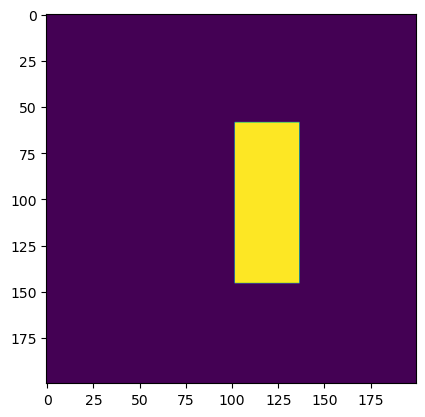

In [28]:
map = file[2][0][2][0][1]
plt.imshow(map)

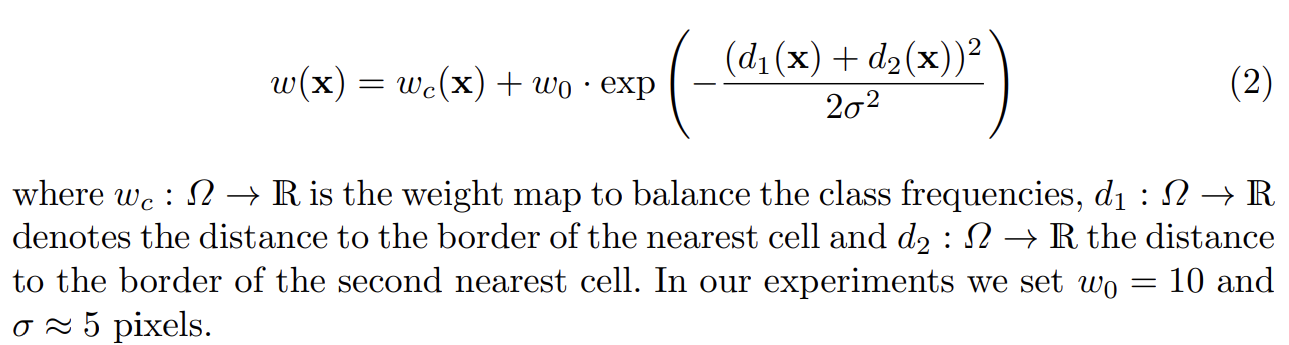

convolove a 5x5 "euclidian distance" kernel with condition if the center is 0

In [39]:
import numpy as np

In [43]:
def genEuclidianDistMatrix(height, width):
    c_x, c_y = height//2, width//2
    
    res = np.zeros((height, width))
    
    for i in range(height):
        for j in range(width):
            res[i, j] = (c_x-i)**2 + (c_y-j)**2
    
    return res
genEuclidianDistMatrix(7, 7)

array([[18., 13., 10.,  9., 10., 13., 18.],
       [13.,  8.,  5.,  4.,  5.,  8., 13.],
       [10.,  5.,  2.,  1.,  2.,  5., 10.],
       [ 9.,  4.,  1.,  0.,  1.,  4.,  9.],
       [10.,  5.,  2.,  1.,  2.,  5., 10.],
       [13.,  8.,  5.,  4.,  5.,  8., 13.],
       [18., 13., 10.,  9., 10., 13., 18.]])

In [79]:
from scipy.signal import convolve2d
import cv2

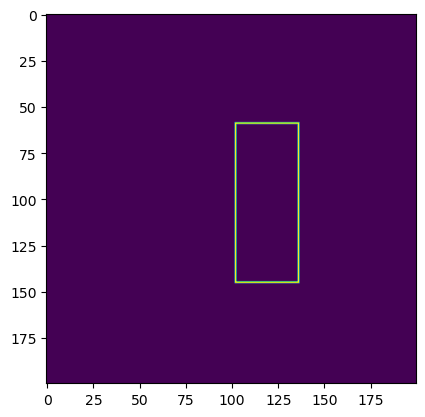

In [172]:
plt.imshow(map - cv2.erode(map.astype(np.uint8), np.ones((3,3))))

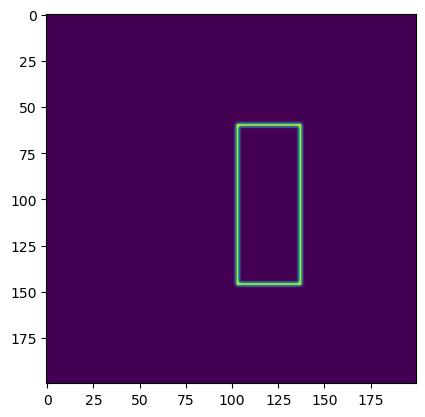

In [87]:
border = map - cv2.erode(map.astype(np.uint8), np.ones((3,3)))

plt.imshow(convolve2d(
    border,
    np.exp(-genEuclidianDistMatrix(20, 20)),
    mode="same"))

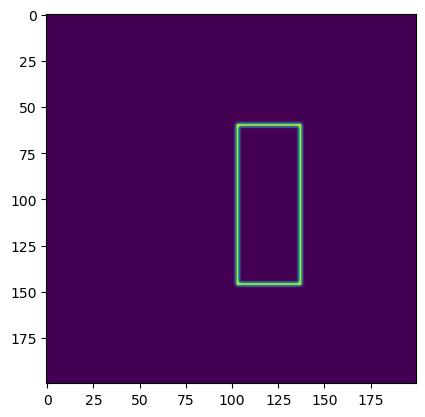

In [143]:
border_w = convolve2d(
    border,
    np.exp(-genEuclidianDistMatrix(10, 10)),
    mode="same") + 1

# border_w[0,0] = 0
plt.imshow(border_w)

Testing binary cross entropt with weight masks

In [93]:
import torch

In [174]:
# weighted loss
loss = torch.nn.BCEWithLogitsLoss(weight=torch.tensor(border_w))

tensor(0.6730)

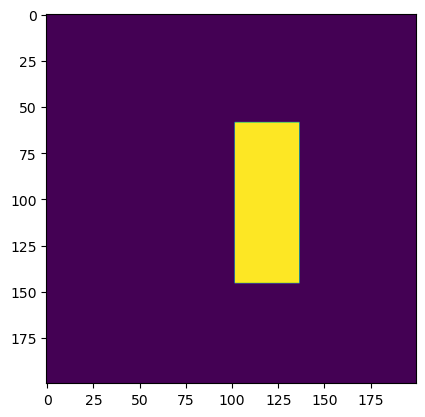

In [177]:
in_t = torch.tensor(map).float()
out_t = torch.tensor((cv2.GaussianBlur(map.astype(np.float32), (7,7), 1))).float()
out_t = torch.tensor(map).float()
# out_t[:50, :50] = 1
plt.imshow(out_t)
loss(out_t, in_t)

#.6762, .6730
#.6661, .6642

In [ ]:
def getWeightedLoss(map, device="cuda"):
    border = map - cv2.erode(map.astype(np.uint8), np.ones((3,3)))
    border_w = convolve2d(
                border,
                np.exp(-genEuclidianDistMatrix(10, 10)),
                mode="same") + 1
    
    return torch.nn.BCEWithLogitsLoss(weight=torch.tensor(border_w).to(device))
    